## import libraries

In [14]:
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

### load datasets

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#zzz = pd.read_csv('sample_submission.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [3]:
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


### Image processing

In [4]:
IMAGE_SIZE = [100, 100]

In [5]:
#for train images
train_image =[]
for name in df_train['image_id']:
    path = 'data/train/'+name+'.jpg'
    img = cv2.imread(path)
    image = cv2.resize(img,(100,100))
    train_image.append(image)

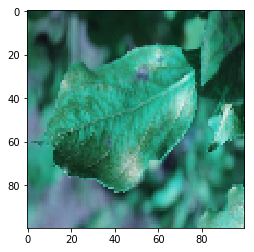

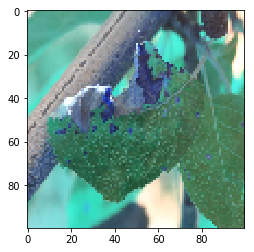

In [6]:
for i in range(2):
    plt.imshow(train_image[i])
    plt.show()

In [7]:
#for test image
test_image =[]
for name in df_test['image_id']:
    path = 'data/test/'+name+'.jpg'
    img = cv2.imread(path)
    image = cv2.resize(img,(100, 100))
    test_image.append(image)

In [8]:
#for train image
train_x = np.ndarray(shape=(len(train_image), 100,100,3), dtype=np.float32)

i=0
for image in train_image:
    train_x[i] = img_to_array(image)
    train_x[i] = train_image[i]
    i = i + 1

train_x = train_x/255

In [9]:
train_x.shape

(1821, 100, 100, 3)

In [10]:
#for test image
test_x = np.ndarray(shape=(len(test_image),100,100,3), dtype= np.float32)

i=0
for image in test_image:
    test_x[i] = img_to_array(image)
    test_x[i] = test_image[i]
    i = i+1

test_x = test_x/255
test_x.shape

(1821, 100, 100, 3)

In [11]:
train_y = df_train.drop('image_id',axis=1)
train_y.head()

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [12]:
train_y = np.array(train_y)
print(train_y.shape, train_y[0])

(1821, 4) [0 0 0 1]


In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y, test_size=0.3)

In [14]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)


In [15]:
# do not train existing weights

for layer in vgg.layers:
    layer.trainable = False
    

In [16]:
#folders = glob('Datasets/train/*')

# we can add more layer if it will be required.
x = Flatten()(vgg.output)

prediction = Dense(4, activation=tf.nn.softmax)(x)

model = Model(inputs= vgg.input, outputs=prediction)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [18]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

In [19]:
# import the images from datasets using ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True)

#test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
# Make sure I provide the same target size as initialied for the image size
'''training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (100, 100),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')'''

"training_set = train_datagen.flow_from_directory('Datasets/train',\n                                                 target_size = (100, 100),\n                                                 batch_size = 32,\n                                                 class_mode = 'categorical')"

In [21]:
'''test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical')'''

"test_set = test_datagen.flow_from_directory('Datasets/test',\n                                            target_size = (100, 100),\n                                            batch_size = 32,\n                                            class_mode = 'categorical')"

In [22]:
# train the model
'''
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)'''

r = model.fit_generator(datagen.flow(x_train, y_train, batch_size=30),
                       epochs=10,
                       steps_per_epoch=x_train.shape[0] // 30,
                       verbose = 1,
                       validation_data = (x_test, y_test))

Epoch 1/10
42/42 [==============================] - 520s 12s/step - loss: 1.2780 - acc: 0.3147 - val_loss: 1.3451 - val_acc: 0.3254
Epoch 2/10
42/42 [==============================] - 557s 13s/step - loss: 1.2736 - acc: 0.3291 - val_loss: 1.3453 - val_acc: 0.3071
Epoch 3/10
42/42 [==============================] - 550s 13s/step - loss: 1.2432 - acc: 0.3255 - val_loss: 1.3537 - val_acc: 0.3144
Epoch 4/10
42/42 [==============================] - 536s 13s/step - loss: 1.2450 - acc: 0.3410 - val_loss: 1.3946 - val_acc: 0.3071
Epoch 5/10
42/42 [==============================] - 544s 13s/step - loss: 1.2581 - acc: 0.3250 - val_loss: 1.3116 - val_acc: 0.3199
Epoch 6/10
42/42 [==============================] - 507s 12s/step - loss: 1.2665 - acc: 0.3378 - val_loss: 1.3703 - val_acc: 0.2870
Epoch 7/10
42/42 [==============================] - 547s 13s/step - loss: 1.2617 - acc: 0.3379 - val_loss: 1.3380 - val_acc: 0.3035
Epoch 8/10
42/42 [==============================] - 493s 12s/step - loss: 1.

In [23]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')

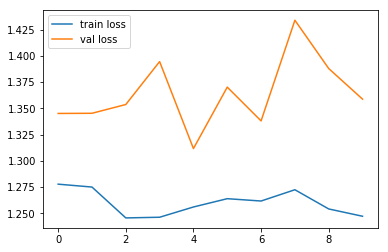

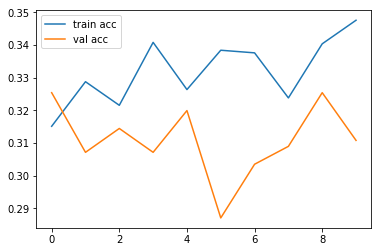

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
model = load_model('model_vgg16.h5')

In [16]:
prediction = model.predict(test_x)

In [31]:
prediction = pd.DataFrame(prediction)
prediction.head()

,healthy,multiple_diseases,rust,scab
0,0.237876,0.045220,0.194479,0.522425
1,0.282786,0.097968,0.333441,0.285805
2,0.112614,0.045551,0.537800,0.304035
3,0.234743,0.060132,0.394941,0.310184
4,0.182095,0.022928,0.298625,0.496352


In [19]:
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [25]:
df_train.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [32]:
prediction.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
prediction.head()

,healthy,multiple_diseases,rust,scab
0,0.237876,0.045220,0.194479,0.522425
1,0.282786,0.097968,0.333441,0.285805
2,0.112614,0.045551,0.537800,0.304035
3,0.234743,0.060132,0.394941,0.310184
4,0.182095,0.022928,0.298625,0.496352


In [37]:
prediction.to_csv('pred.csv')

In [38]:
df_test.to_csv('df_test.csv')

In [39]:
pred = pd.read_csv('pred.csv')
df_tes = pd.read_csv('df_test.csv')

In [40]:
pred.head()

,id,healthy,multiple_diseases,rust,scab
0,0,0.237876,0.045220,0.194479,0.522425
1,1,0.282786,0.097968,0.333441,0.285805
2,2,0.112614,0.045551,0.537800,0.304035
3,3,0.234743,0.060132,0.394941,0.310184
4,4,0.182095,0.022928,0.298625,0.496352


In [41]:
df_tes.head()

,id,image_id
0,0,Test_0
1,1,Test_1
2,2,Test_2
3,3,Test_3
4,4,Test_4


In [43]:
print('test shape :', df_tes.shape)
print('prediction :', pred.shape)

test shape : (1821, 2)
prediction : (1821, 5)


In [46]:
submit = pd.merge(df_tes, pred, on = 'id')
submit.head()

,id,image_id,healthy,multiple_diseases,rust,scab
0,0,Test_0,0.237876,0.045220,0.194479,0.522425
1,1,Test_1,0.282786,0.097968,0.333441,0.285805
2,2,Test_2,0.112614,0.045551,0.537800,0.304035
3,3,Test_3,0.234743,0.060132,0.394941,0.310184
4,4,Test_4,0.182095,0.022928,0.298625,0.496352


In [47]:
submit = submit.drop('id', axis=1)
submit.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.237876,0.045220,0.194479,0.522425
1,Test_1,0.282786,0.097968,0.333441,0.285805
2,Test_2,0.112614,0.045551,0.537800,0.304035
3,Test_3,0.234743,0.060132,0.394941,0.310184
4,Test_4,0.182095,0.022928,0.298625,0.496352


In [48]:
submit.to_csv('submit.csv')